# Test the projection convergence of our basis constructed using OMP

In [1]:
import numpy as np
import scipy as sp
import importlib
import seaborn as sns
import matplotlib.pyplot as plt
import pdb

import omp

importlib.reload(omp)

%matplotlib inline

### Collective OMP algorithm

We construct a measurement basis $W_m$ based on a given approximation basis $V_n$. Our ambient space $V$ is $H_0^1([0,1])$. Here $V_n$ is the sinusoids, normalised in $H_0^1([0,1])$, so $V_n = \mathrm{span}\{\phi_1,\ldots,\phi_n\}$, where $\phi_k = \frac{\sqrt{2}}{\pi k} \sin(k \pi x)$.

The measurements are assumed to be point evaluations, which have representer in $H_0^1$ of
$$
\omega_{x_0}(x) = \frac{1}{\sqrt{x_0 (1-x_0)}}
\begin{cases}
x (1 - x_0) & \text{for } x \le x_0 \\
(1 - x) x_0 & \text{for } x > x_0
\end{cases}
$$

This implementation of the algorithm looks at the best choice of $\omega$ from the dictionary $\mathcal{D}$ against the entire basis $V_n$, hence is called the _collective_ approach. That is, at each step of the algorithm choose
$$
\omega_k 
= \mathrm{argmax}_{\omega\in\mathcal{D}} |\left\langle \omega, v - P_{W_{k-1}} v \right\rangle| 
= \mathrm{argmax}_{\omega\in\mathcal{D}} \| P_{V_n} (\omega - P_{W_{k-1}} \omega ) \|
= \mathrm{argmax}_{\omega\in\mathcal{D}} \sum_{i=1}^n |\left\langle \phi_i - P_{W_{k-1}}\phi_i, \omega \right\rangle|^2
$$
It is precisely the last expression on the right that is used in the code.

### Lets look at $\beta(V_n, W_m)$ for our collective OMP basis and a random basis for comparison

In [ ]:
N = 1e3
dictionary = omp.make_unif_dictionary(N)

ns = [10,20,40]
np.random.seed(3)
#n = 20
m = 200
bs_omp = np.zeros((len(ns), m))
bs_rand = np.zeros((len(ns), m))

Vn = omp.make_sin_basis(ns[-1])
Wms_omp = []
Wms_rand = []

for j, n in enumerate(ns):

    gbc = omp.GreedyBasisConstructor(m, dictionary, Vn.subspace(slice(0,n)), verbose=True)
    Wm_omp = gbc.construct_basis()
    Wms_omp.append(Wm_omp)
    Wm_omp_o = Wm_omp.orthonormalise()

    Wm_rand = omp.make_random_delta_basis(m)
    Wms_rand.append(Wm_rand)
    Wm_rand_o = Wm_rand.orthonormalise()

    for i in range(n, m):
        BP_omp = omp.BasisPair(Wm_omp_o.subspace(slice(0,i)), Vn.subspace(slice(0,n)))
        FB_omp = BP_omp.make_favorable_basis()
        bs_omp[j, i] = FB_omp.beta()

        BP_rand = omp.BasisPair(Wm_rand_o.subspace(slice(0,i)), Vn.subspace(slice(0,n)))
        FB_rand = BP_rand.make_favorable_basis()
        bs_rand[j, i] = FB_rand.beta()
        

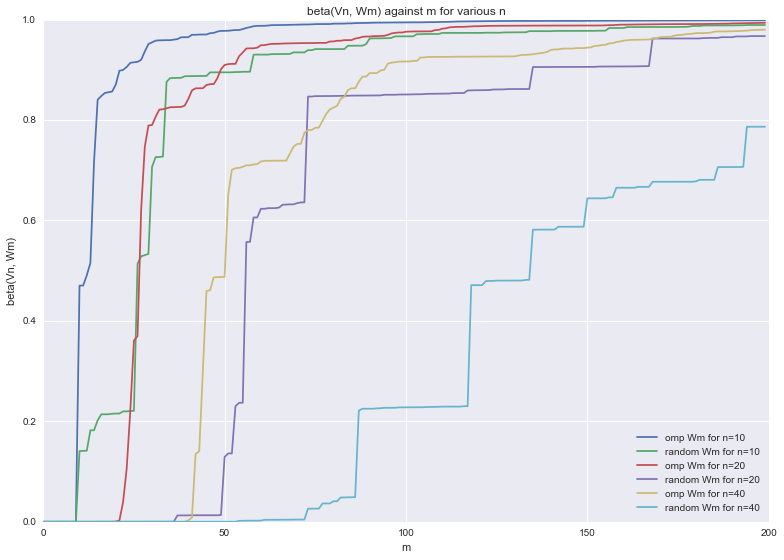

In [3]:
sns.set_palette("deep")
cp = sns.color_palette()

axs = []
fig = plt.figure(figsize=(13, 9))
ax = fig.add_subplot(1, 1, 1, title='beta(Vn, Wm) against m for various n')#, title=r'$\beta(V_n, W_m)$ against $m$ for various $n$')

for i, n in enumerate(ns):
    plt.plot(range(m), bs_omp[i, :], label='omp Wm for n={0}'.format(n))#r'OMP constructed $W_m$, $n={{{0}}}$'.format(n))
    plt.plot(range(m), bs_rand[i, :], label='random Wm for n={0}'.format(n))#r'Random $W_m$, $n={{{0}}}$'.format(n))

ax.set(xlabel='m', ylabel='beta(Vn, Wm)')#r'$m$', ylabel=r'$\beta(V_n, W_m)$')
plt.legend(loc=4)
plt.show()

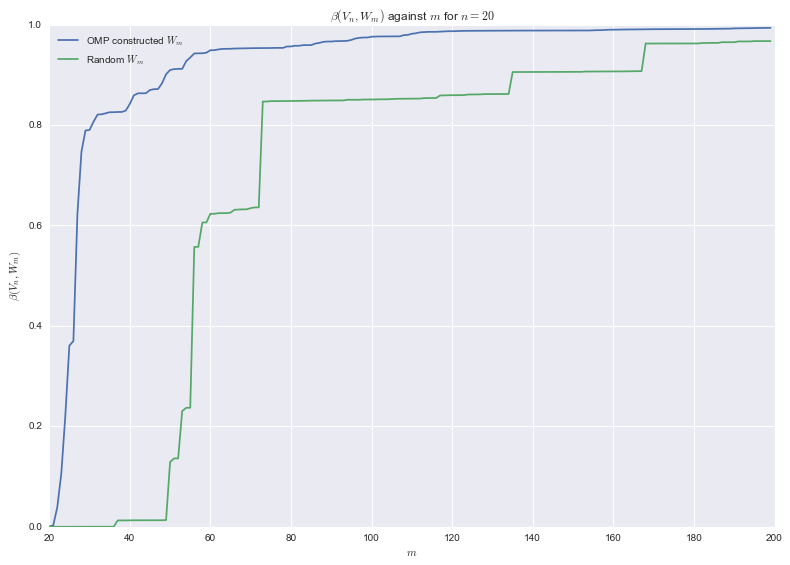

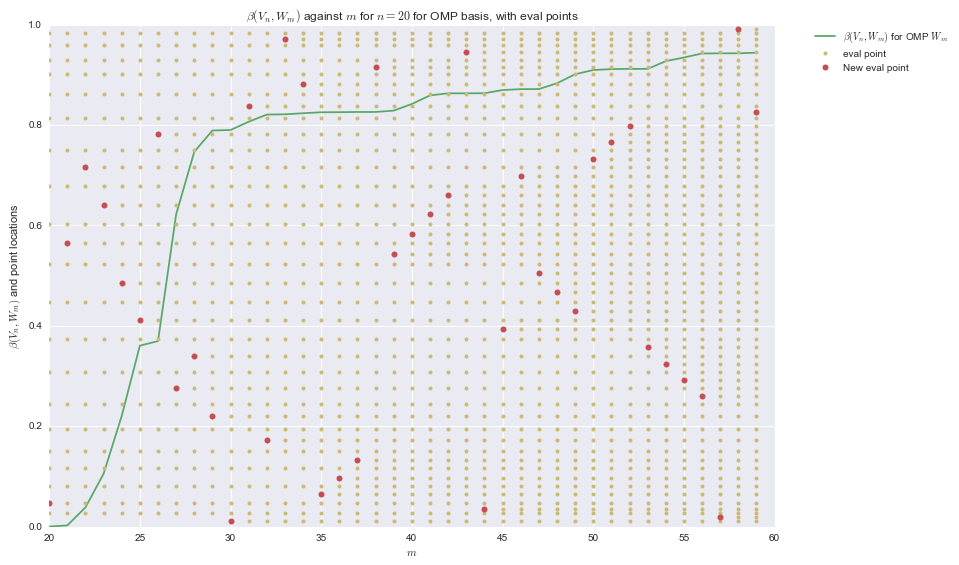

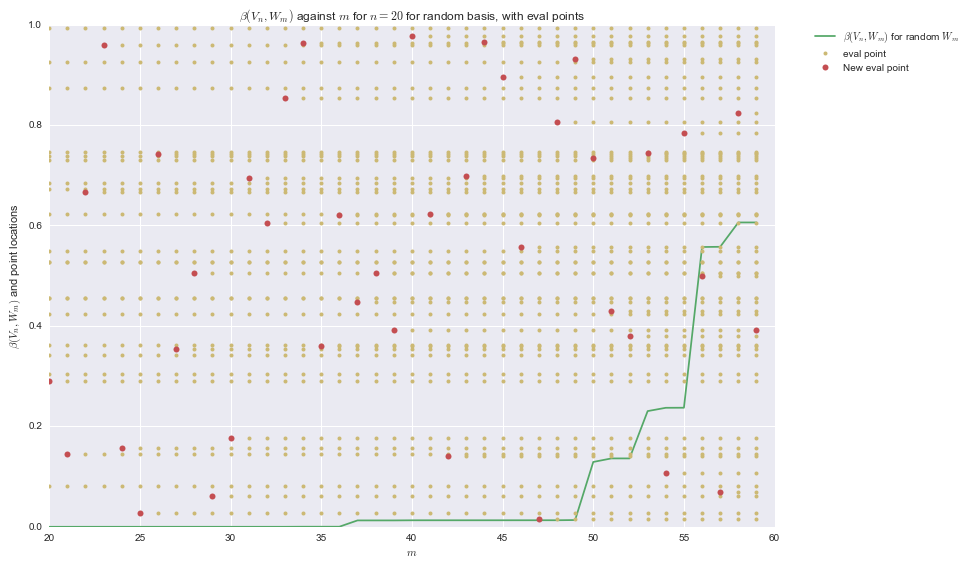

In [5]:
sns.set_palette("deep")
cp = sns.color_palette()

Wm_omp = Wms_omp[1]
Vn = Vn.subspace(slice(0, Wm_omp.n))
b_omp = bs_omp[1,:]
b_rand = bs_rand[1,:]
n=20
m=200

axs = []
fig = plt.figure(figsize=(13, 9))
ax = fig.add_subplot(1, 1, 1, title=r'$\beta(V_n, W_m)$ against $m$ for $n={{{0}}}$'.format(n))

plt.plot(range(n,m), b_omp[n:], label=r'OMP constructed $W_m$')
plt.plot(range(n,m), b_rand[n:], label=r'Random $W_m$')

ax.set(xlabel=r'$m$', ylabel=r'$\beta(V_n, W_m)$')
plt.legend(loc=2)
plt.show()


# Plot the evaluation points in the Wm_rand basis 
# (note that the basis is infact orthonormalised so this isn't *quite* an accurate picture)
Wm_points = [vec.params[0][0] for vec in Wm_omp.vecs]

axs = []
fig = plt.figure(figsize=(13, 9))
ax = fig.add_subplot(1, 1, 1, title=r'$\beta(V_n, W_m)$ against $m$ for $n={{{0}}}$ for OMP basis, with eval points'.format(n))
ax.set(xlabel=r'$m$', ylabel=r'$\beta(V_n, W_m)$ and point locations')
plt.plot(range(n,n+40), b_omp[20:60], color=cp[1], label=r'$\beta(V_n, W_m)$ for OMP $W_m$')

plt.plot(n * np.ones(n-1), Wm_points[:n-1], 'o', color=cp[4], markersize=4, label='eval point')
plt.plot(n, Wm_points[n-1], 'o', color=cp[2], markersize=6, label='New eval point')
for m_plot in range(n, n+40-1):
    plt.plot((m_plot+1) * np.ones(m_plot), Wm_points[:m_plot], 'o', color=cp[4], markersize=4)
    plt.plot(m_plot+1, Wm_points[m_plot], 'o', color=cp[2], markersize=6)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()


# Plot the evaluation points in the Wm_rand basis 
# (note that the basis is infact orthonormalised so this isn't *quite* an accurate picture)
Wm_points = [vec.params[0][0] for vec in Wm_rand.vecs]
Wm_o_coeffs = [vec.coeffs[0] for vec in Wm_rand_o.vecs]

axs = []
fig = plt.figure(figsize=(13, 9))
ax = fig.add_subplot(1, 1, 1, title=r'$\beta(V_n, W_m)$ against $m$ for $n={{{0}}}$ for random basis, with eval points'.format(n))
ax.set(xlabel=r'$m$', ylabel=r'$\beta(V_n, W_m)$ and point locations')
plt.plot(range(n,n+40), b_rand[20:60], color=cp[1], label=r'$\beta(V_n, W_m)$ for random $W_m$')

plt.plot(n * np.ones(n-1), Wm_points[:n-1], 'o', color=cp[4], markersize=4, label='eval point')
plt.plot(n, Wm_points[n-1], 'o', color=cp[2], markersize=6, label='New eval point')
for m_plot in range(n, n+40-1):
    plt.plot((m_plot+1) * np.ones(m_plot), Wm_points[:m_plot], 'o', color=cp[4], markersize=4)
    plt.plot(m_plot+1, Wm_points[m_plot], 'o', color=cp[2], markersize=6)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()


In [ ]:
nb = 40
m = 200
Vn = omp.make_sin_basis(n)

gbc_40 = omp.GreedyBasisConstructor(m, dictionary, Vn, verbose=True)
Wm_omp_40 = gbc_40.construct_basis()
Wm_omp_o_40 = Wm_omp_40.orthonormalise()

Wm_rand = omp.make_random_delta_basis(m)
Wm_rand_o = Wm_rand.orthonormalise()

### Lets look at some bases constructed on the cluster, and examine $m$ vs $n$ for a fixed minimum $\beta$

In [11]:
m=200
ns = [5, 10, 20, 40, 100]
bs_unif = np.zeros((len(ns), m))
bs_rand = np.zeros((len(ns), m))
bs_arb = np.zeros((len(ns), m))

gammas = np.arange(0., 1.1, 0.1)
m_gammas_unif = np.zeros((len(ns), len(gammas)))
m_gammas_rand = np.zeros((len(ns), len(gammas)))
m_gammas_arb = np.zeros((len(ns), len(gammas)))

for j, n in enumerate(ns):
    Vn = omp.make_sin_basis(n)
    
    omp_unif_x = np.load('omp_x_unif_{0}_10000.npy'.format(n))
    Wm_omp_unif = omp.Basis(vecs=[omp.Vector([x], [1.0], ['H1delta']) for x in omp_unif_x])
    Wm_omp_unif_o = Wm_omp_unif.orthonormalise()

    omp_rand_x = np.load('omp_x_rand_{0}_10000.npy'.format(n))
    Wm_omp_rand = omp.Basis(vecs=[omp.Vector([x], [1.0], ['H1delta']) for x in omp_rand_x])
    Wm_omp_rand_o = Wm_omp_rand.orthonormalise()

    Wm_arb = omp.make_random_delta_basis(m)
    Wm_arb_o = Wm_arb.orthonormalise()
    
    for i in range(n, m):
        BP_unif = omp.BasisPair(Wm_omp_unif_o.subspace(slice(0,i)), Vn)
        FB_unif = BP_omp.make_favorable_basis()
        bs_unif[j,i] = FB_unif.beta()

        BP_rand = omp.BasisPair(Wm_omp_rand_o.subspace(slice(0,i)), Vn)
        FB_rand = BP_rand.make_favorable_basis()
        bs_rand[j,i] = FB_rand.beta()
    
        BP_arb = omp.BasisPair(Wm_arb_o.subspace(slice(0,i)), Vn)
        FB_arb = BP_arb.make_favorable_basis()
        bs_arb[j,i] = FB_rand.beta()
    
    # Make the pivot data - the minimum m to reach some beta
    for i, gamma in enumerate(gammas):
        
        m_gammas_unif[j, i] = np.searchsorted(bs_unif[j,:], gamma)
        m_gammas_rand[j, i] = np.searchsorted(bs_rand[j,:], gamma)
        m_gammas_rand[j, i] = np.searchsorted(bs_rand[j,:], gamma)
        

In [ ]:
cp = sns.color_palette()

axs = []
fig = plt.figure(figsize=(13, 9))
ax = fig.add_subplot(1, 1, 1, title=r'$\beta(V_n, W_m)$ against $m$ for $n={{{0}}}$'.format(n))

for i, n in enumerate(ns):
    
    
    plt.plot(range(n,m), b_unif, label=r'OMP constructed $W_m$')
    plt.plot(range(n,m), b_unif, label=r'OMP constructed $W_m$')
    
    
cp = sns.color_palette()

axs = []
fig = plt.figure(figsize=(13, 9))
ax = fig.add_subplot(1, 1, 1, title=r'$\beta(V_n, W_m)$ against $m$ for $n={{{0}}}$'.format(n))

plt.plot(range(n,m), b_omp, label=r'OMP constructed $W_m$')
plt.plot(range(n,m), b_rand, label=r'Random $W_m$')

ax.set(xlabel=r'$m$', ylabel=r'$\beta(V_n, W_m)$')
plt.legend(loc=2)
plt.show()


# Plot the evaluation points in the Wm_rand basis 
# (note that the basis is infact orthonormalised so this isn't *quite* an accurate picture)
Wm_points = [vec.params[0][0] for vec in Wm_omp.vecs]

axs = []
fig = plt.figure(figsize=(13, 9))
ax = fig.add_subplot(1, 1, 1, title=r'$\beta(V_n, W_m)$ against $m$ for $n={{{0}}}$ for OMP basis, with eval points'.format(n))
ax.set(xlabel=r'$m$', ylabel=r'$\beta(V_n, W_m)$ and point locations')
plt.plot(range(n,n+40), b_omp[:40], color=cp[1], label=r'$\beta(V_n, W_m)$ for OMP $W_m$')

plt.plot(n * np.ones(n-1), Wm_points[:n-1], 'o', color=cp[4], markersize=4, label='eval point')
plt.plot(n, Wm_points[n-1], 'o', color=cp[2], markersize=6, label='New eval point')
for m_plot in range(n, n+40-1):
    plt.plot((m_plot+1) * np.ones(m_plot), Wm_points[:m_plot], 'o', color=cp[4], markersize=4)
    plt.plot(m_plot+1, Wm_points[m_plot], 'o', color=cp[2], markersize=6)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()


# Plot the evaluation points in the Wm_rand basis 
# (note that the basis is infact orthonormalised so this isn't *quite* an accurate picture)
Wm_points = [vec.params[0][0] for vec in Wm_rand.vecs]
Wm_o_coeffs = [vec.coeffs[0] for vec in Wm_rand_o.vecs]

axs = []
fig = plt.figure(figsize=(13, 9))
ax = fig.add_subplot(1, 1, 1, title=r'$\beta(V_n, W_m)$ against $m$ for $n={{{0}}}$ for random basis, with eval points'.format(n))
ax.set(xlabel=r'$m$', ylabel=r'$\beta(V_n, W_m)$ and point locations')
plt.plot(range(n,n+40), b_rand[:40], color=cp[1], label=r'$\beta(V_n, W_m)$ for random $W_m$')

plt.plot(n * np.ones(n-1), Wm_points[:n-1], 'o', color=cp[4], markersize=4, label='eval point')
plt.plot(n, Wm_points[n-1], 'o', color=cp[2], markersize=6, label='New eval point')
for m_plot in range(n, n+40-1):
    plt.plot((m_plot+1) * np.ones(m_plot), Wm_points[:m_plot], 'o', color=cp[4], markersize=4)
    plt.plot(m_plot+1, Wm_points[m_plot], 'o', color=cp[2], markersize=6)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()
